<a href="https://colab.research.google.com/github/juhee3199/DeepLearning-keras/blob/main/%EC%8B%A4%EC%8A%B5%EC%BD%94%EB%93%9C/8-2_deep_dream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 딥드림
: 합성곱 신경망이 학습한 표현을 사용하여 예술적으로 이미지를 조작하는 기법

- 컨브넷 상위 층에 있는 특정 필터의 활성화를 극대화 하기 위해 컨브넷의 입력에 경사상승법을 적용.
- 특정 필터가 아닌 전체 층의 활성화를 최대화 한다. 한꺼번에 많은 특성을 섞어 시각화한다.
- 빈 이미지나 노이즈가 조금 있는 입력이 아닌, 이미 가지고 있는 이미지를 사용한다.그 결과 기존 시각패턴을 바탕으로 이미지의 요소들을 다소 예술적인 스타일로 왜곡시킨다.
- 입력 이미지는 시각 품질을 높이기 위해 여러 다른 스케일(옥타브)로 처리한다.

# 8.2.1 케라스 딥드림 구현

어떤 컨브넷을 사용해도 가능. 어떤 컨브넷을 선택했느냐에 따라 시각화에 영향을 미친다.
(각 컨브넷이 학습한 특성이 다르기 때문에)

원래 딥드림에서 사용한 컨브넷은 인셉션모델이기 때문에 인셉션V3 모델을 사용

In [29]:
# 사전 훈련된 인셉션 V3 모델 로드

from keras.applications import inception_v3
from tensorflow.keras import backend as K

K.set_learning_phase(0) # 모델을 훈련하지 않습니다. 이 명령은 모든 훈련연산을 비활성화함.

#합성곱 기반 층만 사용한 인셉션V3 네트워크. 사전훈련된 ImageNet 가중치와 함께 모델로드.
model = inception_v3.InceptionV3(weights='imagenet', include_top=False) 


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


- 손실 계산
: 경사상승법으로 최대화할 값.

여러 층에 있는 모든 필터 활성화를 동시에 최대화한다.

특별히 상위 층에 있는 활성화의 L2norm에 대한 가중치 합을 최대화한다.

하위 층은 기하학적인 패턴을 만들고, 상위 층은 ImageNet에 있는 클래스로 보이는 시각 요소를 만든다. 

In [31]:
# 딥드림 설정
# 어떤 층을 선택할지 파라미터로 설정하여 바꾸기

# 층 이름과 계수를 매핑한 딕셔너리.
# 최대화하려는 손실에 층의 활성화가 기여할 양을 정한다.
# 층 이름은 내장된 인셉션 V3 애플리케이션에 하드코딩되어 있는 것입니다.
# model.summary()를 사용하면 모든 층 이름을 확인할 수 있습니다

layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

In [32]:
#손실 텐서 정의하기
# 위에서 선택한 층의 활성화에 대한 L2norm의 가중치합.

layer_dict = dict([(layer.name, layer) for layer in model.layers]) #층 이름과 층 객체를 매핑한 딕셔너리를 만든다.

loss = K.variable(0.) # 손실을 정의하고 각 층의 기여분을 이 스칼라 변수에 추가하기

for layer_name in layer_contributions:
  coeff = layer_contributions[layer_name]
  activation = layer_dict[layer_name].output # 층의 출력을 얻는다.

  scaling = K.prod(K.cast(K.shape(activation), 'float32'))
  # 층 특성의 L2 노름의 제곱을 손실에 추가합니다. 이미지 테두리는 제외하고 손실에 추가합니다.
  loss = loss + coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling


In [46]:
# 경사 상승법 과정

dream = model.input # 생성된 딥드림 이미지를 저장하는 텐서

grads = K.gradients(loss, dream)[0] # 손실에 대한 딥드림 이미지의 그래디언트를 계산

grads /= K.maximum(K.mean(K.abs(grads)), 1e-7) #그래디언트를 정규화(이 기교가 중요하다.)

# 주어진 입력 이미지에서 손실과 그래디언트 값을 계산할 케라스 function 객체를 생성
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs) 
def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

# 이 함수는 경사 상승법을 여러 번 반복하여 수행합니다
def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...', i, '번째 손실 :', loss_value)
        x += step * grad_values
    return x

- 딥드림 알고리즘

이미지를 처리하기 위한 스케일(옥타브) 리스트를 정의한다.
스케일은 이전 스케일보다 1.4배 크다.(40% 증가)
- 딥드림 과정

: 연속적으로 스케일을 늘리고, 스케일이 증가된 이미지에 디테일을 재주입한다.

1. 각 단계에서 정의한 손실이 최대화되도록 **경사 상승법**을 수행한다.

    경사 상승법이 실행된 후 이미지 크기를 40% 증가시킨다.
2. 이미지에 손실된 디테일을 재주입한다. 

    스케일을 연속적으로 증가시키면서(점점 뭉개지므로) 이미지 상세를 많이 잃지 않도록 
    변경 전과 후의 이미지 차이가 잃어버린 디테일이다.


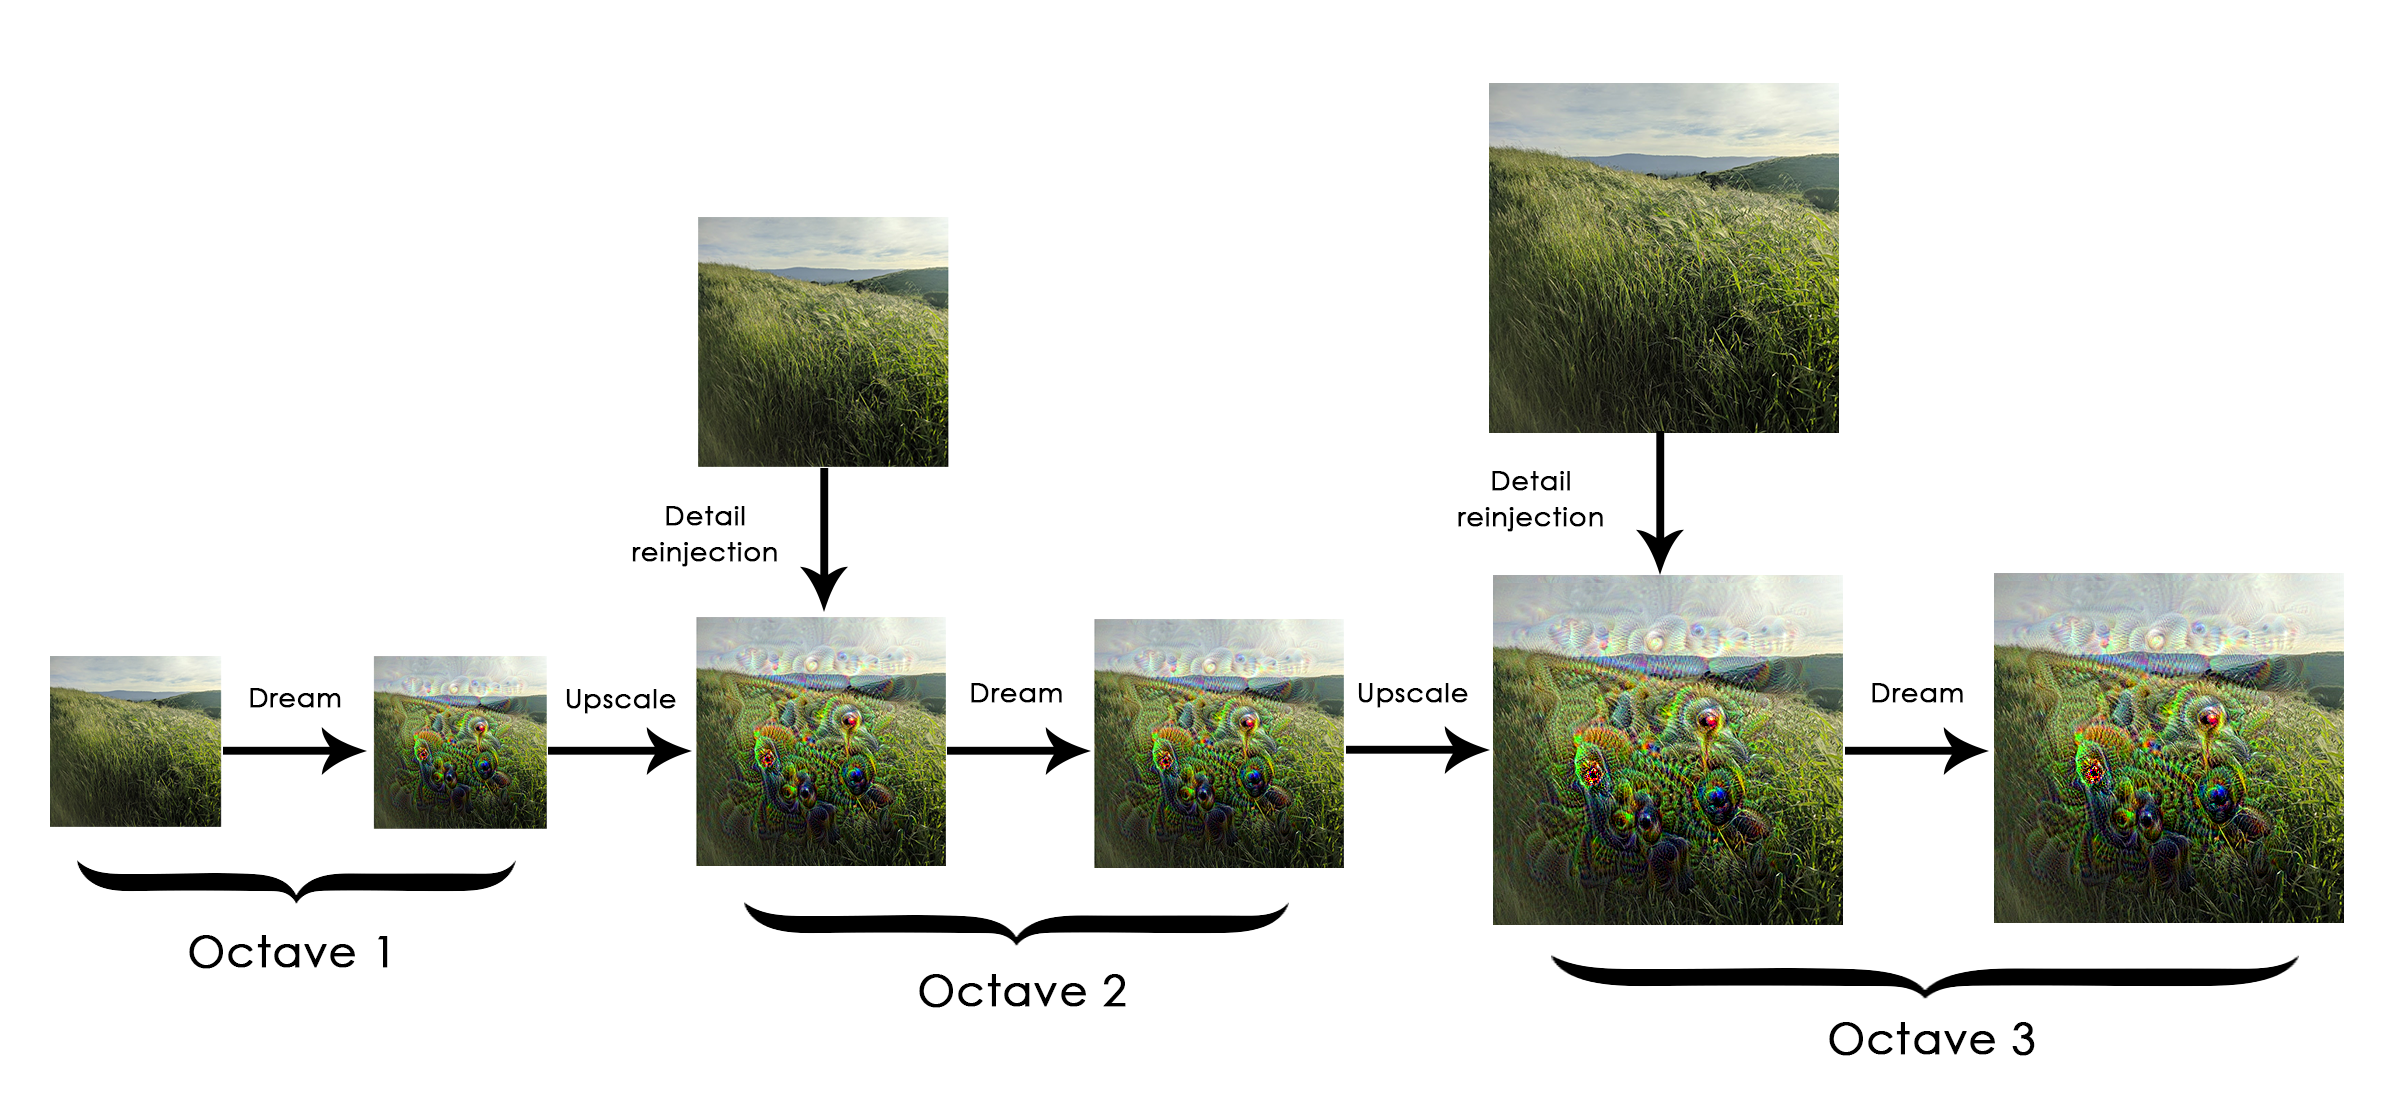

이 코드는 다음에 나오는 유틸리티 함수를 사용한다. 
넘파이 배열 기반의 함수이며 이름으로 역할을 알 수 있다. 
이 함수를 사용하려면 싸이파이를 설치해야 한다.

In [47]:
# 유틸리티 함수

import scipy
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    image.save_img(fname, pil_img)

# V3가 인식하 수 있도록 전처리.
def preprocess_image(image_path):
    # 사진을 열고 크기를 줄이고 인셉션 V3가 인식하는 텐서 포맷으로 변환하는 유틸리티 함수
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


# 넘파이 배열을 적절한 이미지 포맷으로 변환하는 유틸리티 함수
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        # inception_v3.preprocess_input 함수에서 수행한 전처리 과정을 복원합니다
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [49]:
# 연속적인 스케일에 걸쳐 경사 상승법 실행하기

import numpy as np

# 하이퍼파라미터를 바꾸면 새로운 효과가 만들어진다.
step = 0.01  # 경상 상승법 단계 크기
num_octave = 3  # 경사 상승법을 실행할 스케일 단계 횟수
octave_scale = 1.4  # 스케일 간의 크기 비율 = 40% 증가.
iterations = 20  # 스케일 단계마다 수행할 경사 상승법 횟수

# 손실이 10보다 커지면 이상한 그림이 되는 것을 피하기 위해 경사 상승법 과정을 중지한다.
max_loss = 10.

# 사용할 이미지 경로
base_image_path = './original_photo_deep_dream.jpg'

img = preprocess_image(base_image_path) # 기본 이미지를 넘파이 배열로 로드

# 경사 상승법을 실행할 스케일 크기를 정의한 튜플의 리스트를 준비
original_shape = img.shape[1:3]
successive_shapes = [original_shape]

for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

# 이 리스트를 크기 순으로 뒤집습니다
successive_shapes = successive_shapes[::-1]

# 이미지의 넘파이 배열을 가장 작은 스케일로 변경합니다
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('처리할 이미지 크기', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='./final_dream.png')

처리할 이미지 크기 (178, 178)
... 0 번째 손실 : 0.6596175
... 1 번째 손실 : 1.0167829
... 2 번째 손실 : 1.4680847
... 3 번째 손실 : 2.0043144
... 4 번째 손실 : 2.6085465
... 5 번째 손실 : 3.0946984
... 6 번째 손실 : 3.5744772
... 7 번째 손실 : 4.0624814
... 8 번째 손실 : 4.4839563
... 9 번째 손실 : 4.9248023
... 10 번째 손실 : 5.3283157
... 11 번째 손실 : 5.734169
... 12 번째 손실 : 6.1635785
... 13 번째 손실 : 6.505939
... 14 번째 손실 : 6.900894
... 15 번째 손실 : 7.3524327
... 16 번째 손실 : 7.78466
... 17 번째 손실 : 8.1054325
... 18 번째 손실 : 8.473028
... 19 번째 손실 : 9.004365
처리할 이미지 크기 (250, 250)
... 0 번째 손실 : 2.2112575
... 1 번째 손실 : 3.5264554
... 2 번째 손실 : 4.6066394
... 3 번째 손실 : 5.5574446
... 4 번째 손실 : 6.3453116
... 5 번째 손실 : 7.10298
... 6 번째 손실 : 7.8579197
... 7 번째 손실 : 8.600196
... 8 번째 손실 : 9.258043
... 9 번째 손실 : 9.864811
처리할 이미지 크기 (350, 350)
... 0 번째 손실 : 2.3496022
... 1 번째 손실 : 3.5667064
... 2 번째 손실 : 4.680026
... 3 번째 손실 : 5.6887755
... 4 번째 손실 : 6.677289
... 5 번째 손실 : 7.6733265
... 6 번째 손실 : 8.653286
... 7 번째 손실 : 9.899021
